## ETK Filtering

In [1]:
import Simulator
import Observation
import Statistics
import IEWParticleFilter

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [2]:
timestamp = "2021_08_26-12_22_18"

grid, simulator = Simulator.from_file(timestamp)

## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [3]:
statistics = Statistics.Statistics(simulator, N_e=100)

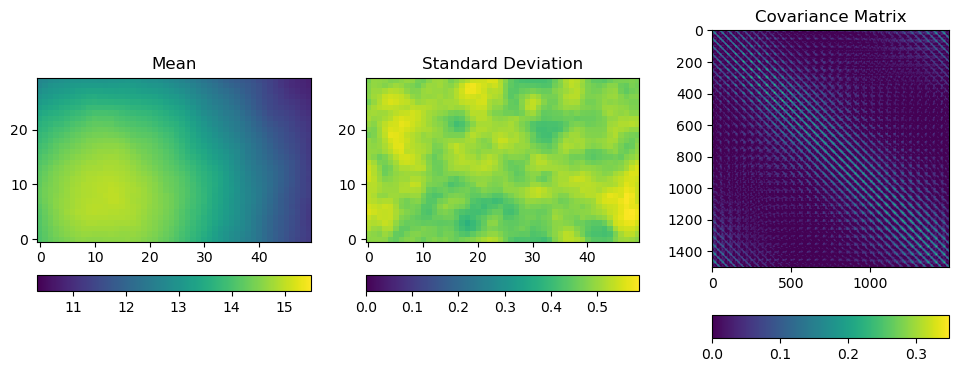

In [4]:
prior_args = Statistics.prior_args_from_file(timestamp)
statistics.set_prior(prior_args)

statistics.plot()

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [5]:
obs_timestamp = "2021_08_26-12_22_28"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


## IEWPF filtering

Updating/conditioning the distributions at every observation time

0


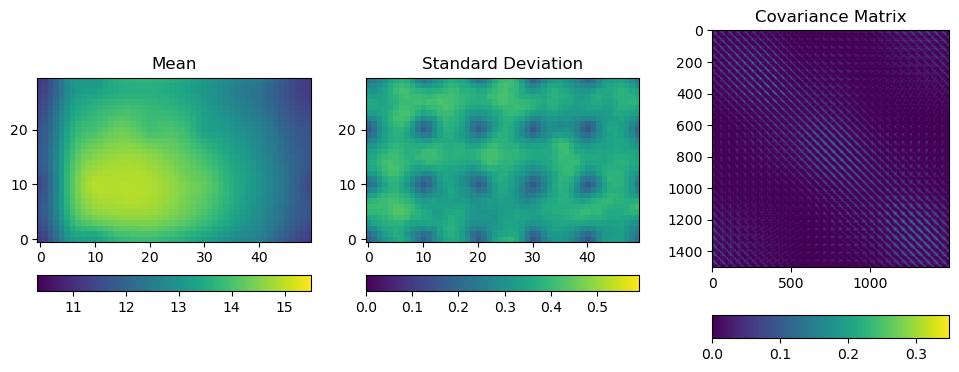

1


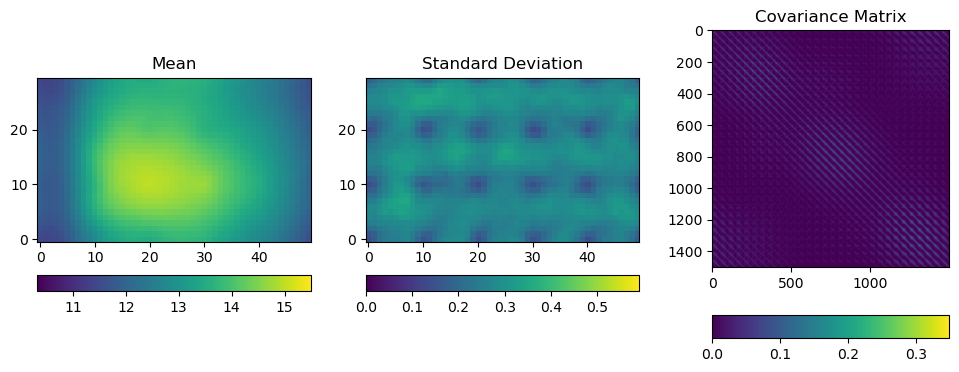

2


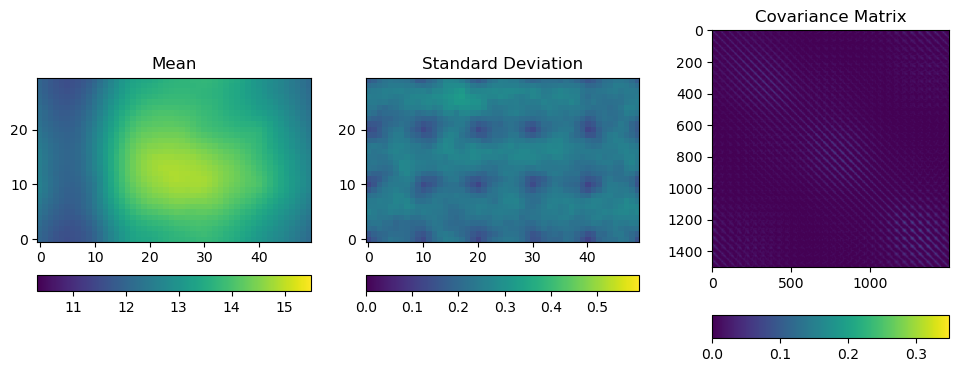

3


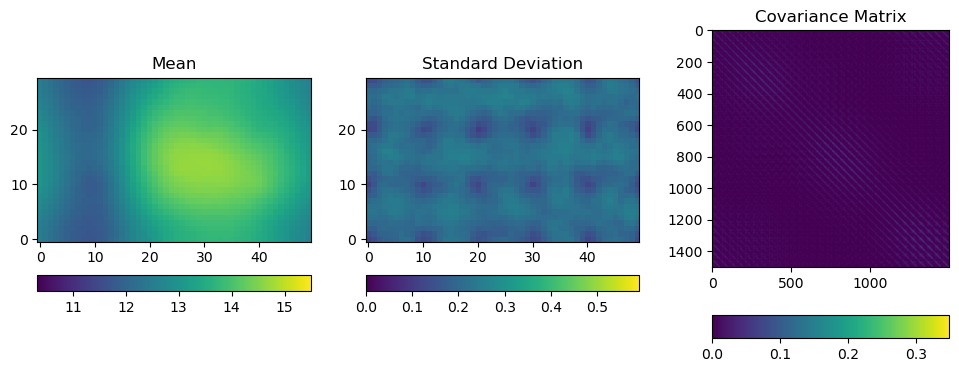

4


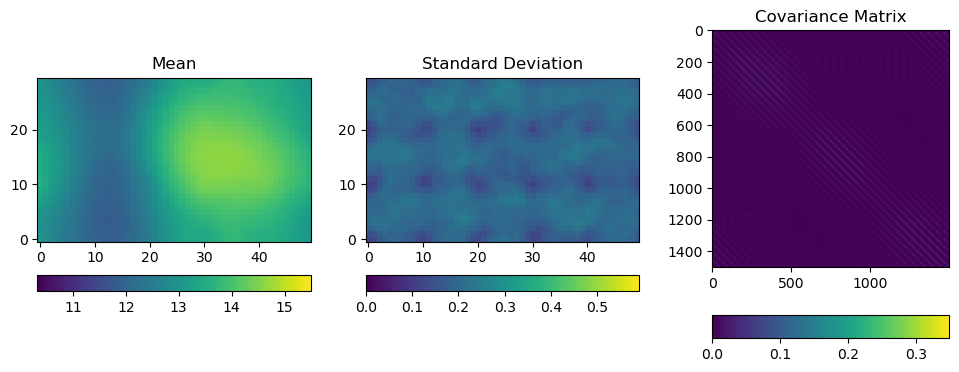

5


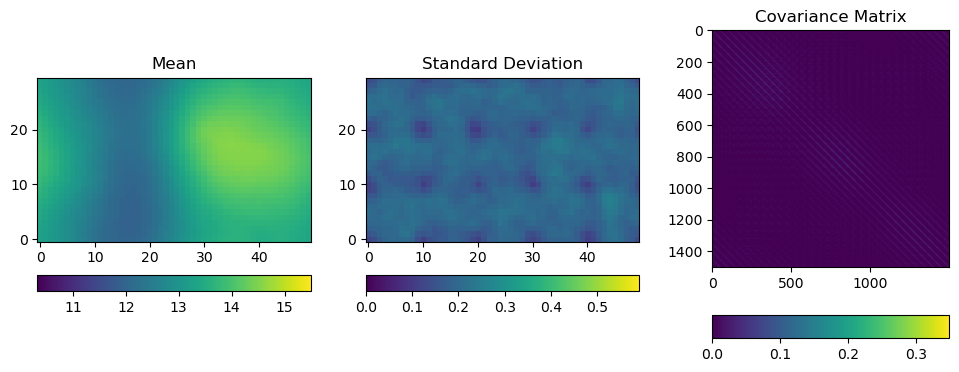

6


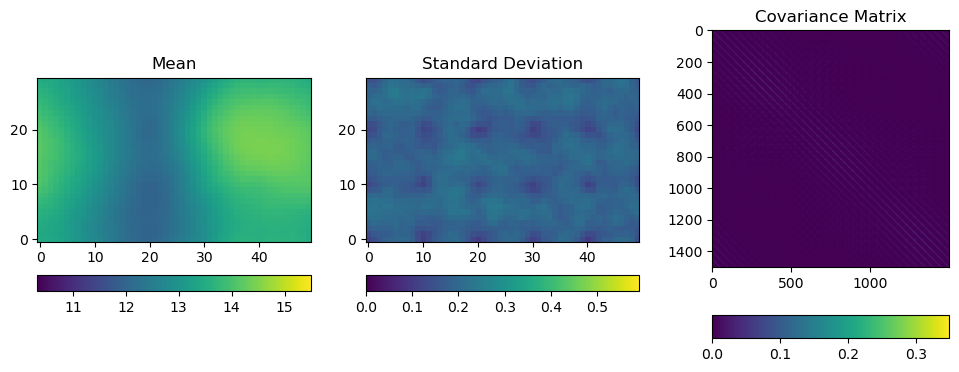

7


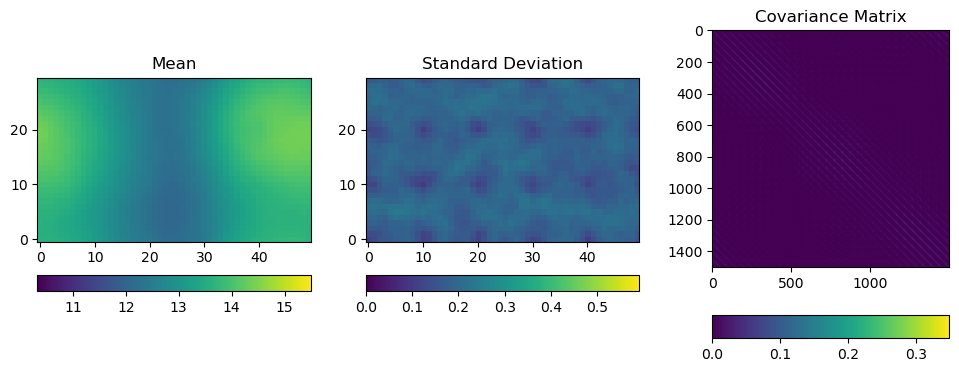

8


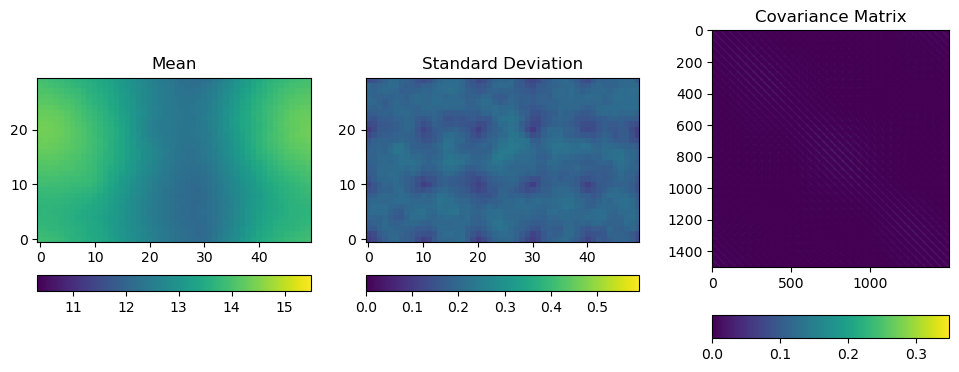

9


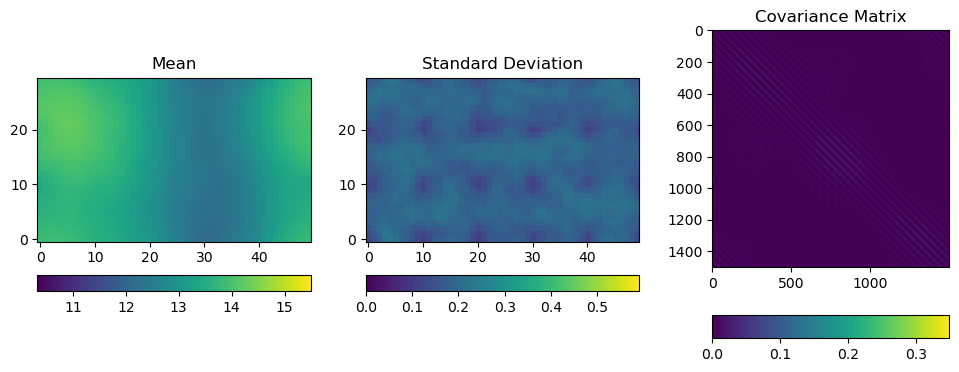

In [6]:
iewpFilter = IEWParticleFilter.IEWParticle(statistics, observation)

for t in range(observation.N_obs):
    print(t)
    statistics.propagate(25, model_error=False)
    iewpFilter.filter(statistics.ensemble.ensemble, observation.obses[t])
    statistics.plot()